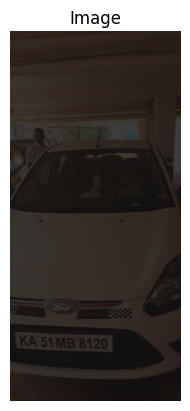

C:\Users\satch\AppData\Local\Temp\ipykernel_4276\2165582751.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


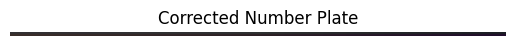

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images in the notebook
def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image (number plate image)
image = cv2.imread('input_image.png')
display_image(image)

### Step 1: Geometric Transformation Correction
# Convert to grayscale for further processing
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect edges to find contours
edges = cv2.Canny(gray_image, 100, 200)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour which should be the number plate
contour = max(contours, key=cv2.contourArea)

# Get the bounding box of the contour
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Apply a perspective transform to correct geometric distortions
width, height = int(rect[1][0]), int(rect[1][1])

# Ensure width is greater than height for correct transformation
if width < height:
    width, height = height, width

# Define destination points for the transformed image
dst_pts = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")

# Get perspective transformation matrix
M = cv2.getPerspectiveTransform(np.array(box, dtype="float32"), dst_pts)

# Warp the image using the transformation matrix
corrected_image = cv2.warpPerspective(image, M, (width, height))

# Display the corrected image
display_image(corrected_image, "Corrected Number Plate")

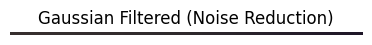

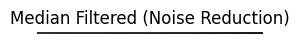

In [2]:
### Step 2: Noise Removal
# Apply Gaussian filter (linear) for noise removal
gaussian_filtered = cv2.GaussianBlur(corrected_image, (5, 5), 0)

# Apply Median filter (non-linear) for noise removal
median_filtered = cv2.medianBlur(corrected_image, 5)

# Display the noise-removed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
display_image(gaussian_filtered, "Gaussian Filtered (Noise Reduction)")

plt.subplot(1, 2, 2)
display_image(median_filtered, "Median Filtered (Noise Reduction)")


In [3]:
### Step 3: Edge Detection & Number Plate Isolation
# Convert to grayscale for edge detection
gray_filtered = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)

# Edge detection using Canny
edges_filtered = cv2.Canny(gray_filtered, 100, 200)

# Find contours again after noise reduction
contours_filtered, _ = cv2.findContours(edges_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plate_contour = max(contours_filtered, key=cv2.contourArea)

# Draw contour around the plate
cv2.drawContours(median_filtered, [plate_contour], -1, (0, 255, 0), 2)

# Extract the plate using the bounding box of the contour
x, y, w, h = cv2.boundingRect(plate_contour)
plate_image = median_filtered[y:y+h, x:x+w]

# Display the isolated plate
display_image(plate_image, "Isolated Number Plate")


ValueError: max() arg is an empty sequence